In [51]:
import os
import glob
import tqdm
import torch
import numpy as np
import omegaconf
from mllib.src.train import main

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch.cuda
from mllib.src.evaluate import evaluate
from mllib.src.utils import prepare_device, load_yaml

In [52]:
# config = "./result/demucs/20230201-104202/config.yaml"
# config = "./result/wav-unet/20230201-104328/config.yaml"
# config = "./result/dcunet/20230201-104116/config.yaml"

# config = "/home/daniel0413/workplace/project/SpeechEnhancement/SpeechEnhancementHL/result/dcunet/20230128-234556/config.yaml"

# config = "./mllib/result/mel-rnn/20230202-145405/config.yaml"
# config = './mllib/result/mel-rnn/20230203-121042/config.yaml'

# config = "./mllib/result/dnn/20230202-142249/config.yaml"
# config = "./mllib/result/dnn/20230202-163959/config.yaml"
# config = "./mllib/result/dnn/20230202-170504/config.yaml"
# config = "./mllib/result/dnn/20230202-171624/config.yaml"
# config = "./mllib/result/dnn/20230202-185453/config.yaml"
# config = "./mllib/result/dnn/20230203-115011/config.yaml"

# config= "./mllib/result/unet/20230203-183804/config.yaml"

# config= "./mllib/result/conv-tasnet/20230203-183838/config.yaml"
# config= "./result/conv-tasnet/20230207-080249/config.yaml"
# config= "./result/conv-tasnet/20230207-184607/config.yaml"    # samples only including target's period, PIT
# config= "./result/conv-tasnet/20230207-185011/config.yaml"    # including all samples, PIT
config= "./result/conv-tasnet/20230208-175200/config.yaml"    # including all samples and no PIT

In [53]:
solver = main(path_config=config, return_solver=True)

------------------------------
	Search training datasets...
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S00275_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 22800
	 Norm:  z-score
	 Sample rate:  16000
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S05812_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 300
	 Norm:  z-score
	 Sample rate:  16000
Train 19380, Validation 3420, Test 300
------------------------------
	Loading data loader...
	The number of CPU:  20
------------------------------
	Loading Model...
ConvTasNet(
  (encoder): Encoder(
    (conv1d_U): Conv1d(2, 128, kernel_size=(40,), stride=(20,), bias=False)
  )
  (separator): TemporalConvNet(
    (network): Sequential(
      (0): ChannelwiseLayerNorm()
      (1): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (2): Sequential(
        (0): Sequential(
 

In [54]:
model = solver.model

In [55]:
args = load_yaml(config)
n_gpu = torch.cuda.device_count()
device = prepare_device(n_gpu, cudnn_deterministic=args.solver.cudnn_deterministic)

Using CuDNN deterministic mode in the experiment.


In [56]:
args.dset.name = "Clarity"
# args.dset.name = "VoiceBankDEMAND"

if args.dset.name == "VoiceBankDEMAND":
    log_voicebank = "./mllib/data/VoiceBankDEMAND/DS_10283_2791/logfiles"
    text_files = glob.glob(
        os.path.join(log_voicebank, "*trainset*")
    )
    print(text_files)
    metadata = []
    for text_file in text_files:
        with open(text_file, "r") as tmp:
            text = tmp.read().split("\n")
            for i, t in enumerate(text):
                text[i] = t.split(" ")
        
            metadata.append(text)
    print(metadata[0][0])

elif args.dset.name == "Clarity":
    log_clarity = "/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/custom_metadata/scenes.train.snr.json"
    metadata = omegaconf.OmegaConf.load(log_clarity)
    print(list(metadata.values())[0], list(metadata.keys())[0])

1.1382 S00001


In [57]:
from mllib.src.distrib import get_train_wav_dataset

SNR = '0' # '0', '5', '10', '15' # SNR = P_{Signal} / P_{Noise}

test_dataset = None

if args.dset.name == "VoiceBankDEMAND":
    args.dset.wav = './mllib/data/VoiceBankDEMAND/DS_10283_2791'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset)

elif args.dset.name == "Clarity":
    args.dset.wav = '/home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data'
    args.default.config = './recipes/icassp_2023/MLbaseline/config_train.yaml'
    train_dataset, validation_dataset, test_dataset = get_train_wav_dataset(config=args.dset)

dataset = test_dataset

flag_find = False
data_test = None

if args.dset.name == "VoiceBankDEMAND":
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, sources, origial_length, name = data
        for imetadata in range(len(metadata)):
            for ifile in range(len(metadata[imetadata])):
                if metadata[imetadata][ifile][0] == name:
                    if metadata[imetadata][ifile][-1] == SNR:
                        flag_find = True
                    else:
                        break
        if flag_find:
            data_test = data
            break

elif args.dset.name == "Clarity":
    # data_test = dataset[0]
    # mixture, clean, origial_length, name = data_test
    # scene_name = name.split("_")[0]
    # SNR = metadata[scene_name]
    # print("Clarity dataset SNR: ", SNR)

    SNR = 5
    for data in tqdm.tqdm(dataset, ncols=120):
        mixture, sources, origial_length, name = data
        scene_name = name.split("_")[0]
        if metadata[scene_name] > SNR:
            data_test = data
            SNR = metadata[scene_name]
            break
    
    print("Clarity dataset SNR: ", SNR)

# data_test

	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S00652_mix_CH2.wav
	 Offset: 0
	 Limit: None
	 Final length: 22800
	 Norm:  z-score
	 Sample rate:  16000
	 Sample file: /home/olive-samba/sambashare/data/Sound/clarity_ICASSP2023/clarity_CEC2_data/clarity_data/train/scenes/S02457_mix_CH1.wav
	 Offset: 0
	 Limit: None
	 Final length: 300
	 Norm:  z-score
	 Sample rate:  16000
Train 19380, Validation 3420, Test 300


  1%|▌                                                                                  | 2/300 [00:00<01:07,  4.39it/s]

Clarity dataset SNR:  5.3746


In [58]:
mixture, sources, origial_length, name = data_test

In [59]:
mixture.shape

torch.Size([2, 90171])

In [60]:
from mllib.src.model.types import (MULTI_SPEECH_SEPERATION_MODELS,
                MULTI_CHANNEL_SEPERATION_MODELS,
                MONARCH_SPEECH_SEPARTAION_MODELS, 
                STFT_MODELS,
                WAV_MODELS,)

nchannel, nsample = mixture.shape
num_spk = sources.shape[1]

# mono channel to stereo for source separation models
assert args.model.audio_channels == nchannel, f"Channel between {args.dset.name} and {args.model.name} did not match..."
assert args.model.num_spk == num_spk, f"number of speakers between {args.dset.name} and {args.model.name} did not match..."

if args.model.name in MULTI_SPEECH_SEPERATION_MODELS:
    assert num_spk == len(args.model.sources), f"number of speakers between {args.dset.name} and {args.model.name} did not match..."

# if not source separation models, merge batch and channels
if args.model.name in MONARCH_SPEECH_SEPARTAION_MODELS:
    mixture = torch.reshape(mixture, shape=(nchannel, 1, nsample))


ImportError: cannot import name 'MULTI_SPEECH_SEPERATION_MODELS' from 'mllib.src.model' (/home/daniel0413/workplace/project/SpeechEnhancement/SpeechEnhancementHL-Clarity/mllib/src/model/__init__.py)

In [ ]:
mixture.shape, args.model.name

(torch.Size([2, 90171]), 'conv-tasnet')

In [ ]:
enhanced = evaluate(mixture=mixture[None], model=model, device=device, config=args)
enhanced = torch.squeeze(enhanced, dim=0)

In [ ]:
enhanced.shape, sources.shape

(torch.Size([2, 2, 90171]), torch.Size([2, 2, 90171]))

In [ ]:
enhanced = enhanced.detach().cpu()
sources = sources.detach().cpu()

if args.model.name in MULTI_SPEECH_SEPERATION_MODELS:
    enhanced = enhanced[:, 0, ...]
    sources = sources[:, 0, ...]



In [ ]:
enhanced.shape, sources.shape, mixture.shape

(torch.Size([2, 90171]), torch.Size([2, 90171]), torch.Size([2, 90171]))

In [ ]:
enhanced_np = enhanced
mixture_np = mixture
sources_np = sources

In [ ]:
enhanced_np = enhanced_np.flatten().numpy()
mixture_np = mixture_np.flatten().numpy()
sources_np = sources_np.flatten().numpy()

In [ ]:
enhanced_np.shape, mixture_np.shape, sources_np.shape

((180342,), (180342,), (180342,))

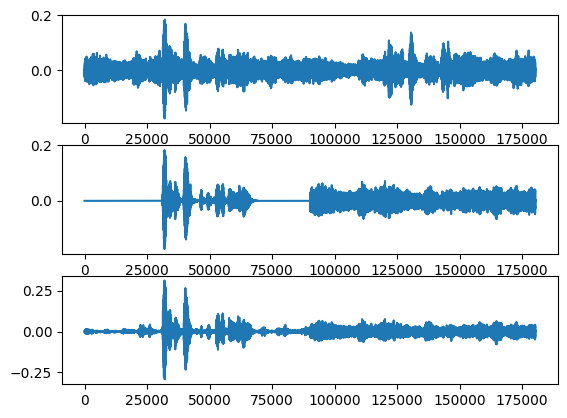

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3)

ax0.plot(mixture_np)
ax1.plot(sources_np)
ax2.plot(enhanced_np)


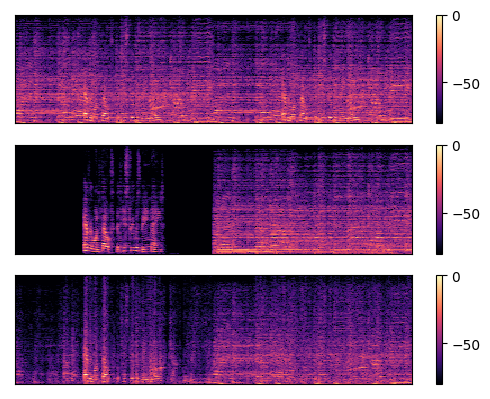

In [ ]:
fig, (ax0, ax1, ax2,) = plt.subplots(nrows=3, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(mixture_np, fig, ax0)
show_stft(sources_np, fig, ax1)
show_stft(enhanced_np, fig, ax2)

In [ ]:
ipd.Audio(mixture_np, rate=args.dset.sample_rate)

In [ ]:
ipd.Audio(sources_np, rate=args.dset.sample_rate)

In [ ]:
ipd.Audio(enhanced_np, rate=args.dset.sample_rate)

In [ ]:
from mllib.src.metric import SI_SDR, STOI, WB_PESQ

In [ ]:
metrics = [SI_SDR, STOI, WB_PESQ]

sources_score = np.expand_dims(np.expand_dims(sources_np, 0), 0)
mixture_score = np.expand_dims(np.expand_dims(mixture_np, 0), 0)
enhanced_score = np.expand_dims(np.expand_dims(enhanced_np, 0), 0)

print(sources_score.shape, mixture_score.shape, enhanced_score.shape)

for metric in metrics:
    print("Mixture", metric, metric(sources_score, mixture_score, sr=args.dset.sample_rate))
    print("Enhanced", metric, metric(sources_score, enhanced_score, sr=args.dset.sample_rate))

(1, 1, 180342) (1, 1, 180342) (1, 1, 180342)
Mixture <function SI_SDR at 0x7f7f477eb040> -3.831029534339905
Enhanced <function SI_SDR at 0x7f7f477eb040> 6.251605153083801
Mixture <function STOI at 0x7f7f2be5a280> 0.549187153778015
Enhanced <function STOI at 0x7f7f2be5a280> 0.7724679134152083
Mixture <function WB_PESQ at 0x7f7f2be5a310> 0
Enhanced <function WB_PESQ at 0x7f7f2be5a310> 0
